Using device: cuda:0
(480, 20)
(480, 20)
(1440, 20)
(1440, 20)


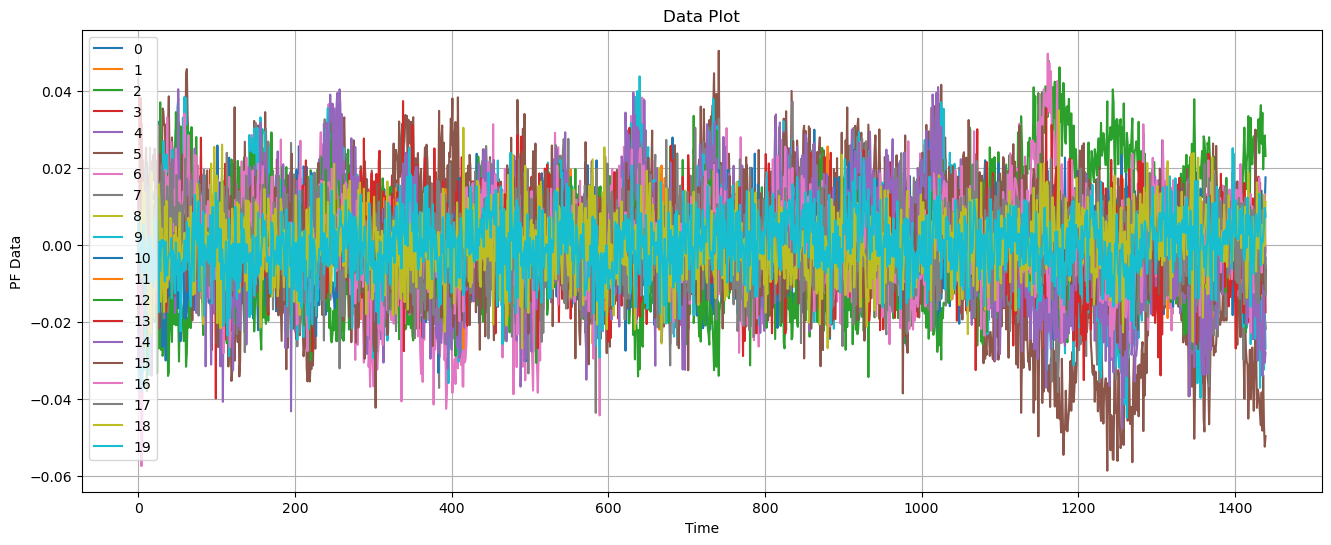

In [125]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from tqdm import tqdm
from scipy.io import loadmat
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

def read_excel_power(file_path= ""):
    pfData = pd.read_excel(file_path, engine='openpyxl', sheet_name=0, parse_dates=['Timestamp'])
    phaseData = pd.read_excel(file_path, engine='openpyxl', sheet_name=1, parse_dates=['Timestamp'])
    inject = pd.read_excel(file_path, engine='openpyxl', sheet_name=2, parse_dates=['Timestamp'])
    pfData.set_index('Timestamp', inplace=True)
    phaseData.set_index('Timestamp', inplace=True)
    inject.set_index('Timestamp', inplace=True)
    pfData= pfData.to_numpy()
    phaseData= phaseData.to_numpy()
    inject= inject.to_numpy()
    print(inject.shape)
    pfData= pfData+inject*1e13
    #normalize
    pfData= pfData/(np.sqrt(np.sum(np.square(pfData), 1, keepdims= True)))
    pfData= pfData-np.mean(pfData, 0, keepdims= True)
    print(pfData.shape)
    
    return pfData, phaseData
attackPfData, attackPhaseData= read_excel_power("first round/attack_all.xlsx")
PfData2, attackPhaseData2= read_excel_power("fdia_data.xlsx")
# basePfData, basePhaseData= read_excel_power("first round/base_all.xlsx")
data= PfData2
plt.figure(figsize=(16, 6))
for i in range(data.shape[1]):
    #plt.plot(data.index, data[i], label=i)
    plt.plot(data[:, i], label=i)
plt.title('Data Plot')
plt.xlabel('Time')
plt.ylabel('PF Data')
plt.legend()
plt.grid(True)
plt.show()

In [85]:
# Load MATLAB file
mat_data = loadmat('matpower/topology20_14.mat')

# Access a variable inside the .mat file
A = mat_data['graph']
# 'data' is a NumPy array
print(A.shape)


(20, 14)


In [30]:
neighbor= 1
type0PfData= np.concatenate([PfData2[0:950,:], PfData2[1370:,:]])
xDatas= np.concatenate([type0PfData])
attackPfData2= PfData2[0:, :]
print(xDatas.shape)
def create_neighbor_data(dataI, neighbor):
    lenth= dataI.shape[0]
    dataO= []
    for i in range(neighbor+1, lenth-neighbor):

        dataO.append([dataI[i-neighbor-1:i+neighbor, :]])
    return np.concatenate(dataO)
oDatas= create_neighbor_data(xDatas, neighbor=neighbor)
print(oDatas.shape)

(1020, 20)
(1017, 3, 20)


In [31]:

# Define the model
class Net(nn.Module):
    def __init__(self, A, neighbor):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(20, 18)   # Input layer
        self.fc12 = nn.Linear(18, 16)   # Input layer
        self.fc13 = nn.Linear(16, 14)   # Input layer
        self.neighbor= neighbor
        self.fc2 = nn.Linear(14, 20)
        self.H = torch.randn((20, 14), dtype= torch.float64, device=device)*1e-6 # Hidden layer
        self.H= torch.nn.Parameter(self.H)
        self.A= torch.tensor(A, device= device)
        self.VecBias= torch.randn((1, 14), dtype= torch.float64, device=device)*1e-6
        self.VecBias= torch.nn.Parameter(self.VecBias)
        
    def encoder(self, x):
        y1current= x[:, 1, :]
        y1 = self.fc1(y1current)
        y1 = self.fc12(y1)
        y1 = self.fc13(y1)
        y1= y1+torch.rand((y1.shape[0], 1), device= device)
        return y1
    def decoder(self, y1):
        #x = (torch.abs(self.H)*self.A).matmul((y1).T)
        x= self.fc2(y1)
        return x
    def forward(self, x):
        y1, y2= self.encoder(x)
        x_pre= self.decoder(y1, y2)
        return x_pre
# Create the model and move it to the GPU
model = Net(A, neighbor).to(device, dtype=torch.float64)
losses= []

In [32]:


# Convert data to PyTorch tensors
x_tensor = torch.tensor(oDatas, dtype=torch.float64, device=device)

# Create a DataLoader
dataset = TensorDataset(x_tensor, x_tensor)
loader = DataLoader(dataset, batch_size=1024, shuffle=True)

# Loss function and optimizer
# criterion = nn.MSELoss()
criterion= nn.HuberLoss(delta=1)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0)



In [37]:
# Training the model
epochs = 20000
for epoch in tqdm(range(epochs)):
    for inputs, label in loader:
        optimizer.zero_grad()
        y1 = model.encoder(inputs)
        p_x = model.decoder(y1)
        MSELoss = criterion(p_x, inputs[:, neighbor, :])
        loss= MSELoss
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

print("Training complete.")
print(loss)
print(MSELoss)

100%|██████████| 20000/20000 [02:54<00:00, 114.55it/s]

Training complete.
tensor(1.1169e-08, device='cuda:0', dtype=torch.float64,
       grad_fn=<HuberLossBackward0>)
tensor(1.1169e-08, device='cuda:0', dtype=torch.float64,
       grad_fn=<HuberLossBackward0>)


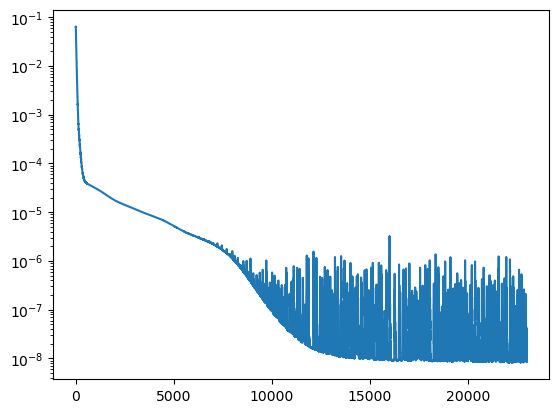

In [38]:
plt.plot(losses[:])
plt.yscale("log")
#plt.xscale("log")

(1437,)


Text(0, 0.5, '|y^2|')

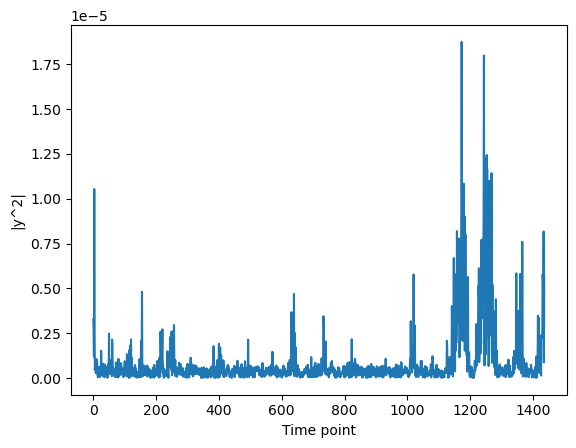

In [39]:
attackPfData2O =create_neighbor_data(attackPfData2, neighbor=neighbor)

x_test_tensor = torch.tensor(attackPfData2O, dtype=torch.float64, device=device)
y1= model.encoder(x_test_tensor)
o_x= model.decoder(y1)
bias= torch.square(x_test_tensor[:, neighbor,:]-o_x).sum(1).detach().cpu().numpy()
print(bias.shape)
ob_o_y= torch.sum(torch.square(y1), dim= 1)
plt.plot(bias)
plt.xlabel("Time point")
plt.ylabel("|y^2|")

(477,)


Text(0, 0.5, '|y^2|')

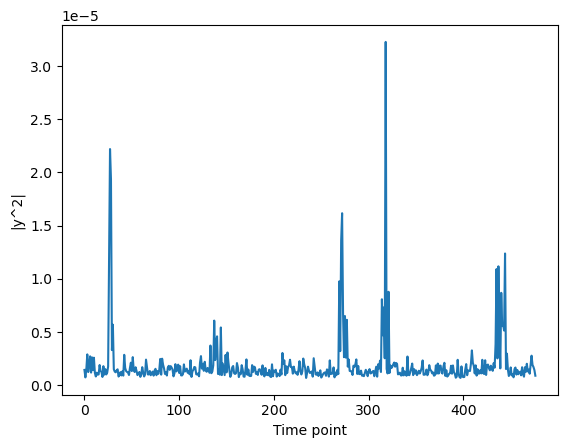

In [23]:
attackPfData2O =create_neighbor_data(attackPfData, neighbor=neighbor)

x_test_tensor = torch.tensor(attackPfData2O, dtype=torch.float64, device=device)
y1= model.encoder(x_test_tensor)
o_x= model.decoder(y1)
bias= torch.square(x_test_tensor[:, neighbor,:]-o_x).sum(1).detach().cpu().numpy()
print(bias.shape)
ob_o_y= torch.sum(torch.square(y1), dim= 1)
plt.plot(bias)
plt.xlabel("Time point")
plt.ylabel("|y^2|")